# Teste de Hipóteses - Pense Estatística, 2º Edição.

## Universidade Federal de Alagoas - UFAL
## Centro de Tecnologia - CTEC
## Programa de Pós-Graduação Recursos Hídricos e Saneamento - PPGRHS
### Disciplina de Estatística

Clebson Farias

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random

import thinkstats2
import thinkplot

In [2]:
#Dados Manso
dados = pd.read_csv("manso.csv", index_col=0, parse_dates=True)
dados_naturais = dados.MANSO.dropna(axis=0, how='all')
dados_naturais.head()

1982-01-01    243.0
1982-01-02    329.0
1982-01-03    290.0
1982-01-04    300.0
1982-01-05    386.0
Name: MANSO, dtype: float64

In [3]:
dados_chuva = dados['1455008'].dropna(axis=0, how='all').groupby(pd.Grouper(freq='A-AUG')).sum()[1:-4]
dados_chuva.head()

1982-08-31     945.5
1983-08-31     980.3
1984-08-31    1696.6
1985-08-31    1573.1
1986-08-31    1032.7
Freq: A-AUG, Name: 1455008, dtype: float64

In [4]:
inicio_ano = 'AUG'
def annual(dados, month_start_year_hydrologic):
    data_by_year_hydrologic = dados.groupby(pd.Grouper(freq='AS-%s' % month_start_year_hydrologic))
    max_vazao = data_by_year_hydrologic.max().values
    idx_vazao = data_by_year_hydrologic.idxmax().values
    
    peaks = pd.DataFrame(max_vazao, index=idx_vazao, columns=['Peaks'])
    return peaks

def mean_annual(dados, month_start_year_hydrologic):
    data_by_year_hydrologic = dados.groupby(pd.Grouper(freq='AS-%s' % month_start_year_hydrologic))
    mean = data_by_year_hydrologic.max().values
    
    return pd.Series(mean, name = 'Mean')
data_peaks = annual(dados_naturais, inicio_ano)[:-1]
data_mean = mean_annual(dados_naturais, inicio_ano)[:-1]
data_peaks.head()

,Peaks
1982-02-03,1126.0
1983-01-19,1193.0
1983-12-02,1118.0
1985-01-08,1157.0
1986-02-21,1088.0


In [5]:
def remove_outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return df[trueList]

dados_rmv = remove_outlier(data_peaks).dropna(axis=0, how='all')

In [6]:
fit = stats.gumbel_r.fit(data_peaks.values)
print('Localização: {};\n\
Escala: {}'.format(round(fit[0], 3), round(fit[1], 3)))

Localização: 1016.141;
Escala: 283.321


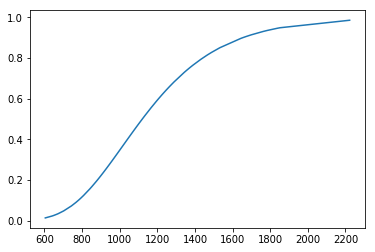

In [7]:
dist_gam = stats.gumbel_r(fit[0], fit[1])
x_gam = dist_gam.rvs(size=100)
y_gam = dist_gam.cdf(x_gam)
plt.plot(np.sort(x_gam), np.sort(y_gam))

In [8]:
shape, loc, scale = stats.lognorm.fit(data_mean, floc=0)
shape, loc, scale

(0.2808379750934478, 0.0, 1123.2693609802732)

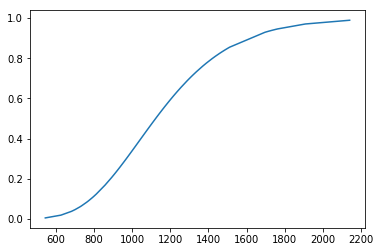

In [9]:
dist_log = stats.lognorm(0.28, 0, 1123.269)
x_log = dist_log.rvs(100)
y_log = dist_log.cdf(x_log)
plt.plot(np.sort(x_log),np.sort(y_log))

In [10]:
mean_peaks = data_peaks.mean().values[0]
std_peaks = data_peaks.std().values[0]
print('Média: ', round(mean_peaks, 3), '\nDesvio Padrãos: ', round(std_peaks, 3))

Média:  1167.324 
Desvio Padrãos:  330.911


## Teste de hipóteses classicas

A questão fundamental que queremos abordar é se os efeitos que observamos numa amostra são prováveis de aparecer na população maior.

- **Teoria da decisão:**
    - Teste de hipótese nula de Fisher;
    - Lema de Neyman-Pearson;
    - Inferência Bayesiana.
- Uma hipótese estatística é **uma afirmação sobre os parâmetros** de uma ou mais população;
- Como representamos a população por meio de distribuições, podemos fazer afirmações sobre os seus parâmetros.
- A hipótese envolve um ou mais parâmetros da distribuição;

Passos:
1. Quantificar o efeito aparante sobre a escolha do teste estatístico;
2. Definir as hipótese a ser testada:
    - **Hipótese nula**, é a hipótese que desejamos testar ($H_{0}$);
    - **Hipótese Alternativa**, é a hipótese contrária da hipótese nula ($H_{1}$);
3. Calcular o valor-p, qual a probalidade da hipótese nula ser verdadeira;
4. Interpretar o resultado. Se o valor-p é baixo, o efeito é considerado estatisticamente significante.

## Teste de hipótese
5% é o valor limite para ser estatística significante. Se o p-value é inferior a 5%, o efeito é considerado significande; caso contrário não.
- A escolha do limite do valor-p depende:
    - Do teste de estatística;
    - Do modelo de hipótese nula;        
- O valor-p não deve ser considerado como métrica de precisão.
- Valores de P entre 1% e 10% devem ser considerados limites.
    - Valor-p < 1%, o efeito não foi por acaso;
    - Valor-p > 10%, o efeito é plausivel;
    - 1% < Valor-p < 10%, consideramos como limite; 

In [51]:
class CoinTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

ct = CoinTest((140, 120))
pvalue = ct.PValue()
pvalue

0.237

## Testando diferença entre as médias

In [12]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [20]:
data_log = data_mean.values, x_log
ht_log = DiffMeansPermute(data_log)
pvalue = ht_log.PValue()
pvalue

0.593

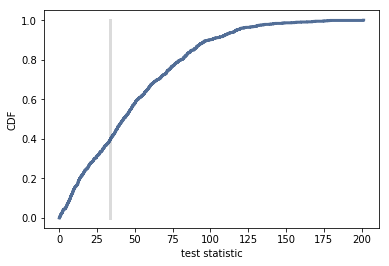

In [14]:
ht_log.PlotCdf()
thinkplot.Config(xlabel='test statistic', ylabel='CDF')

In [27]:
x_gam = dist_gam.rvs(size=34)
data_gam = data_peaks['Peaks'].values, x_gam
ht_gam= DiffMeansPermute(data_gam)
pvalue = ht_gam.PValue()
pvalue

0.531

## Outras estatísticas de teste
- Escolher o melhor estatística de teste depende do questionamento.

In [28]:
class DiffStdPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.std() - group2.std())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [29]:
ht_log_std = DiffStdPermute(data_log)
pvalue_std = ht_log_std.PValue()
pvalue_std

0.693

## Testando uma correlação

In [30]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [31]:
data_corr_log = dados_chuva.values, data_mean.values
ht_corr_log = CorrelationPermute(data_corr_log)
pvalue = ht_corr_log.PValue()
pvalue

0.013

In [32]:
class CorrelationPermute2(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.SpearmanCorr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [33]:
data_scorr_log = dados_chuva.values, data_mean.values
ht_scorr_log = CorrelationPermute2(data_scorr_log)
pvalue = ht_scorr_log.PValue()
pvalue

0.01

## Chi-Quadrado

In [34]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        self.observed, self.expected = data
        test_stat = sum(abs(self.observed - self.expected))
        return test_stat

    def RunModel(self):
        n = len(self.expected)
        values = self.observed
        rolls = np.random.choice(values, n, replace=True)

        return rolls, self.expected

In [43]:
x_log2 = dist_log.rvs(34)
data_log_test = data_mean.values, x_log2
ht_log_test = DiceTest(data_log_test)
pvalue = ht_log_test.PValue()
pvalue

0.052

In [44]:
class DiceChiTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed, expected = data
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat
    
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [46]:
data_chi_test = data_mean.values, x_log2
ht_chi_test = DiceChiTest(data_chi_test)
pvalue = ht_chi_test.PValue()
pvalue

0.276

## 9

In [47]:
class PregLengthTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        observado, esperado = data
        stat = self.ChiSquared(observado) + self.ChiSquared(esperado)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat
    
    def MakeModel(self):
        observado, esperado = self.data
        self.n = len(observado)
        self.pool = np.hstack((observado, esperado))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = observado
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [49]:
data_chi_test2 = data_mean.values, x_log2
ht_chi_test2 = PregLengthTest(data_chi_test2)
pvalue = ht_chi_test2.PValue()
pvalue

0.513

## Erros

- **Falso positivo:** Se o efeito é realmente devido ao acaso, qual é a probabilidade de ser considerado significante?
- **Falso negativo:** Se o efeito for real, qual é a chance do teste de hipótese falhar?